In [1]:
from PrepareTheData3 import GetTheInput_Single
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import itertools



Using TensorFlow backend.


In [ ]:

#***** Get the Values from Pandas *****
df = GetTheInput_Single("filename.csv")
dataset = df.values
X = dataset[:, 0:132]
Y = dataset[:, 132]
#**************************************


#********** Normalize the Input Values ************
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)
#**************************************************


#********** Cut Values to 3 piecies ************
#Normalized
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
#Raw
X_train_Raw, X_val_and_test_Raw, Y_train_Raw, Y_val_and_test_Raw = train_test_split(X, Y, test_size=0.3)
X_val_Raw, X_test_Raw, Y_val_Raw, Y_test_Raw = train_test_split(X_val_and_test_Raw, Y_val_and_test_Raw, test_size=0.5)
#print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
#***********************************************



In [ ]:


#********** Build the Model and Compile ************
model = Sequential()
model.add(Dense(128, input_dim=132, kernel_initializer='normal', activation='relu'))
model.add(Dense(32, kernel_initializer='normal', activation='relu'))
model.add(Dense(16, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#***************************************************


#********** Train the Model ********************
hist = model.fit(X_train, Y_train,batch_size=2048, epochs=20,validation_data=(X_val, Y_val))
#***********************************************


#********** Test the Model on New Data ********************
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)
#*********************************************************


#********** Perform predictions on new Dataset ********************
predictions = model.predict(X_test)
#******************************************************************



In [ ]:


#********** Calculate the Stats ********************
# 1.Define stats variables
TotalTrades = 0
GoodTrades = 0
counter = 0
WeekDayStats = {'Monday':[0,0],'Tuesday':[0,0],'Wendsday':[0,0],'Thursday':[0,0],'Friday':[0,0]}
ConsequtiveStats = []

PredictedResults = []

LastWon = False
Weekdays = round(len(predictions)/7200,0)


# 2.Loop through predictions
for prediction_check in predictions:
    if prediction_check > 0.90 or prediction_check < 0.10:
        # Predictions above threshold

        TotalTrades = TotalTrades+1
        Map_Raw_Data = X_test_Raw[counter]
        
     
        
        # Check if won or lost
        WonLost_WeekDay_Coutner = 0
        if np.argmax(predictions[counter]) == Y_test[counter]:
            # Won
            GoodTrades = GoodTrades + 1
            WonLost_WeekDay_Coutner = 0
            ConsequtiveStats.append(1)
            
        else:
            WonLost_WeekDay_Coutner = 1
            ConsequtiveStats.append(0)
            
            
        if Map_Raw_Data[3] == 0: WeekDayStats['Monday'][WonLost_WeekDay_Coutner] = WeekDayStats['Monday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 0.25: WeekDayStats['Tuesday'][WonLost_WeekDay_Coutner] = WeekDayStats['Tuesday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 0.5: WeekDayStats['Wendsday'][WonLost_WeekDay_Coutner] = WeekDayStats['Wendsday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 0.75: WeekDayStats['Thursday'][WonLost_WeekDay_Coutner] = WeekDayStats['Thursday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 1: WeekDayStats['Friday'][WonLost_WeekDay_Coutner] = WeekDayStats['Friday'][WonLost_WeekDay_Coutner] + 1
        
            
            
            
    counter = counter + 1

# 3. Append stats variables

z = [(x[0], len(list(x[1]))) for x in itertools.groupby(ConsequtiveStats)]    

MaxLost = 0
MaxWon = 0

for a in z:
    if a[0]==0:
        if a[1] > MaxLost: MaxLost = a[1]
    else:
        if a[1] > MaxWon: MaxWon = a[1]



#Get average trades per week
for key, value in WeekDayStats.items():
    value[0] = round(value[0]/Weekdays,0)
    value[1] = round(value[1]/Weekdays,0)

print ('Trades: ' + str(TotalTrades) + ' -- ' + 'Good trades: ' + str(GoodTrades) + ' -- ' + 'Percantage: ' + str(round(((GoodTrades/TotalTrades)*100),2))+ '%')


#******************************************************************





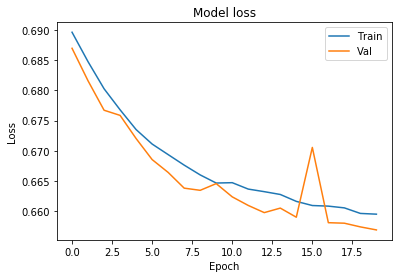

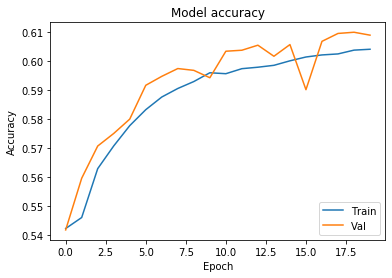

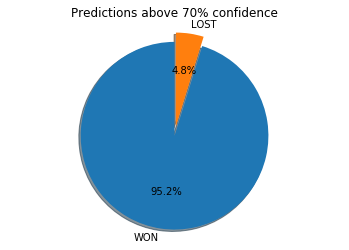

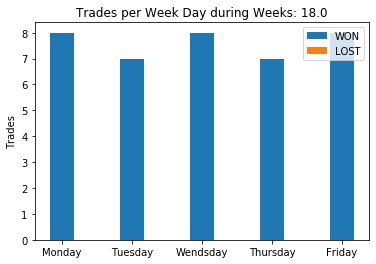

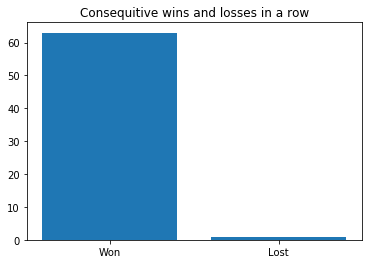

In [111]:



#********** Create the Charts Dashboard ********************

# Chart 1 - Model Loss
#plt.subplot(331)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


# Chart 2 - Model Accuracy
#plt.subplot(332)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


# Chart 3 - Lost and Won trades % above 70%
#plt.subplot(333)
labels = 'WON', 'LOST'
sizes = [GoodTrades, (TotalTrades-GoodTrades)]
explode = (0, 0.1)  
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Predictions above 70% confidence')
plt.show()


# Chart 4 - Average Trades per week day

#plt.subplot(334)
N = 5
TradesWonWeekDay = (WeekDayStats['Monday'][0]+WeekDayStats['Monday'][1], 
                    WeekDayStats['Tuesday'][0]+WeekDayStats['Tuesday'][1],
                    WeekDayStats['Wendsday'][0]+WeekDayStats['Wendsday'][1], 
                    WeekDayStats['Thursday'][0]+WeekDayStats['Thursday'][1], 
                    WeekDayStats['Friday'][0]+WeekDayStats['Friday'][1])
TradesLostWeekDay = (WeekDayStats['Monday'][1], WeekDayStats['Tuesday'][1], WeekDayStats['Wendsday'][1], WeekDayStats['Thursday'][1], WeekDayStats['Friday'][1])



ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, TradesWonWeekDay, width)
p2 = plt.bar(ind, TradesLostWeekDay, width)

plt.ylabel('Trades')
plt.title('Trades per Week Day during Weeks: ' + str(Weekdays))
plt.xticks(ind, ('Monday', 'Tuesday', 'Wendsday', 'Thursday', 'Friday'))
plt.legend((p1[0], p2[0]), ('WON', 'LOST'))
plt.show()


# Chart 5 - Consequtive Losses and Wins
#plt.subplot(335)
plt.title('Consequitive wins and losses in a row')
x = np.arange(2)
money = [MaxWon,MaxLost]
plt.bar(x, money)
plt.xticks(x, ('Won','Lost'))


#**************************************
plt.show()
#******************************************************************


In [112]:
#***** Get the Values from Pandas *****
df = GetTheInput_Single("EURUSD_M1_NEW.csv")
dataset = df.values
XX = dataset[:, 0:132]
YY = dataset[:, 132]
#**************************************

In [113]:
#********** Normalize the Input Values ************
min_max_scaler = preprocessing.MinMaxScaler()
XX_scale = min_max_scaler.fit_transform(XX)
#**************************************************

In [114]:

#********** Test the Model on New Data ********************
test_loss, test_acc = model.evaluate(XX, YY)
print('Test accuracy:', test_acc)
#*********************************************************

#********** Perform predictions on new Dataset ********************
predictions = model.predict(XX_scale)
#******************************************************************



44145/44145 [==============================] - 3s 73us/step
Test accuracy: 0.5606977007683143


In [115]:

#********** Calculate the Stats ********************
# 1.Define stats variables
TotalTrades = 0
GoodTrades = 0
counter = 0
WeekDayStats = {'Monday':[0,0],'Tuesday':[0,0],'Wendsday':[0,0],'Thursday':[0,0],'Friday':[0,0]}
ConsequtiveStats = []

PredictedResults = []

LastWon = False
Weekdays = round(len(predictions)/7200,0)


# 2.Loop through predictions
for prediction_check in predictions:
    if prediction_check > 0.90 or prediction_check < 0.20:
        # Predictions above threshold

        TotalTrades = TotalTrades+1
        Map_Raw_Data = XX[counter]
        
     
     
        # Check if won or lost
        WonLost_WeekDay_Coutner = 0
        if np.argmax(predictions[counter]) == YY[counter]:
            # Won
            GoodTrades = GoodTrades + 1
            WonLost_WeekDay_Coutner = 0
            ConsequtiveStats.append(1)
            
        else:
            WonLost_WeekDay_Coutner = 1
            ConsequtiveStats.append(0)
            
            
        if Map_Raw_Data[3] == 0: WeekDayStats['Monday'][WonLost_WeekDay_Coutner] = WeekDayStats['Monday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 0.25: WeekDayStats['Tuesday'][WonLost_WeekDay_Coutner] = WeekDayStats['Tuesday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 0.5: WeekDayStats['Wendsday'][WonLost_WeekDay_Coutner] = WeekDayStats['Wendsday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 0.75: WeekDayStats['Thursday'][WonLost_WeekDay_Coutner] = WeekDayStats['Thursday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 1: WeekDayStats['Friday'][WonLost_WeekDay_Coutner] = WeekDayStats['Friday'][WonLost_WeekDay_Coutner] + 1
        
         
            
            
    counter = counter + 1

# 3. Append stats variables

z = [(x[0], len(list(x[1]))) for x in itertools.groupby(ConsequtiveStats)]    

MaxLost = 0
MaxWon = 0

for a in z:
    if a[0]==0:
        if a[1] > MaxLost: MaxLost = a[1]
    else:
        if a[1] > MaxWon: MaxWon = a[1]



#Get average trades per week
for key, value in WeekDayStats.items():
    value[0] = round(value[0]/Weekdays,0)
    value[1] = round(value[1]/Weekdays,0)

print ('Trades: ' + str(TotalTrades) + ' -- ' + 'Good trades: ' + str(GoodTrades) + ' -- ' + 'Percantage: ' + str(round(((GoodTrades/TotalTrades)*100),2))+ '%')


#******************************************************************


Trades: 18 -- Good trades: 16 -- Percantage: 88.89%


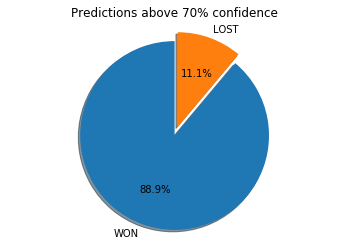

(0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0)


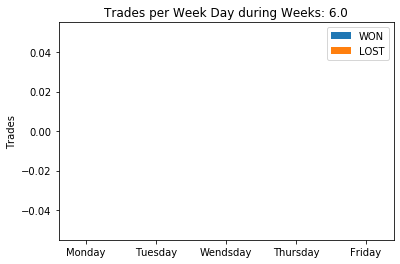

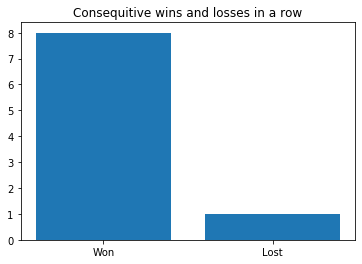

In [116]:

#********** Create the Charts Dashboard ********************


# Chart 3 - Lost and Won trades % above 70%
#plt.subplot(333)
labels = 'WON', 'LOST'
sizes = [GoodTrades, (TotalTrades-GoodTrades)]
explode = (0, 0.1)  
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Predictions above 70% confidence')
plt.show()


# Chart 4 - Average Trades per week day

#plt.subplot(334)
N = 5
TradesWonWeekDay = (WeekDayStats['Monday'][0]+WeekDayStats['Monday'][1], 
                    WeekDayStats['Tuesday'][0]+WeekDayStats['Tuesday'][1],
                    WeekDayStats['Wendsday'][0]+WeekDayStats['Wendsday'][1], 
                    WeekDayStats['Thursday'][0]+WeekDayStats['Thursday'][1], 
                    WeekDayStats['Friday'][0]+WeekDayStats['Friday'][1])
TradesLostWeekDay = (WeekDayStats['Monday'][1], WeekDayStats['Tuesday'][1], WeekDayStats['Wendsday'][1], WeekDayStats['Thursday'][1], WeekDayStats['Friday'][1])
print(TradesWonWeekDay)
print(TradesLostWeekDay)

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, TradesWonWeekDay, width)
p2 = plt.bar(ind, TradesLostWeekDay, width)

plt.ylabel('Trades')
plt.title('Trades per Week Day during Weeks: ' + str(Weekdays))
plt.xticks(ind, ('Monday', 'Tuesday', 'Wendsday', 'Thursday', 'Friday'))
plt.legend((p1[0], p2[0]), ('WON', 'LOST'))
plt.show()


# Chart 5 - Consequtive Losses and Wins
#plt.subplot(335)
plt.title('Consequitive wins and losses in a row')
x = np.arange(2)
money = [MaxWon,MaxLost]
plt.bar(x, money)
plt.xticks(x, ('Won','Lost'))


#**************************************
plt.show()
#******************************************************************
